In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [2]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

In [3]:
# tensorflow graph
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
net = x_image
net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)

temp=tf.reshape(net,[-1,14*14,36])
Gram=tf.matmul(tf.transpose(temp,[0,2,1]),temp)

net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
net = tf.contrib.layers.flatten(net)
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)
logits = net
y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W0408 20:29:33.084733 140337330829120 deprecation.py:323] From <ipython-input-3-0462c040b7d1>:8: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0408 20:29:33.088807 140337330829120 deprecation.py:506] From /home/ramanlab/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0408 20:29:33.232897 140337330829120 deprecation.py:323] From <ipython-input-3-0462c040b7d1>:9: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0408 20:29:34.140691 1403373308291

In [4]:
session = tf.Session()
session.run(tf.global_variables_initializer())


In [5]:
x_batch, y_true_batch, _ = data.random_batch(batch_size=64)
x_batch.dtype

dtype('float64')

In [6]:
train_batch_size = 64
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations
    
def style_matrix(x_batch):
#     x_mean=data.x_train[0,:]
    feed_dict_train = {x: x_batch}
    gram = session.run(Gram, feed_dict=feed_dict_train)
    return gram

# x_batch, y_true_batch, _ = data.random_batch(batch_size=1)
# answer=style_matrix(x_batch)

In [7]:
%%time
optimize(num_iterations=10000)


# conv_names.append('layer_fc1/BiasAdd')

Optimization Iteration:      1, Training Accuracy:  14.1%
Optimization Iteration:    101, Training Accuracy:  85.9%
Optimization Iteration:    201, Training Accuracy:  85.9%
Optimization Iteration:    301, Training Accuracy:  92.2%
Optimization Iteration:    401, Training Accuracy:  95.3%
Optimization Iteration:    501, Training Accuracy:  96.9%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  96.9%
Optimization Iteration:    901, Training Accuracy:  98.4%
Optimization Iteration:   1001, Training Accuracy:  92.2%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  98.4%
Optimization Iteration:   1501, Training Accuracy: 100.0%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization I

In [8]:
def get_conv_layer_names():
    graph = tf.get_default_graph()
    
    # Create a list of names for the operations in the graph
    # for the Inception model where the operator-type is 'Conv2D'.
    names = [op.name for op in graph.get_operations() if op.type=='Conv2D']

    return names
conv_names = get_conv_layer_names()

In [9]:
# Computation graph for optimizing input image
def optimize_image(conv_id=None, feature=0,
                   num_iterations=30, show_progress=True, weight=None):
    """
    Find an image that maximizes the feature
    given by the conv_id and feature number.

    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last fully-connected layer
             before the softmax output.
    feature: Index into the layer for the feature to maximize.
    num_iteration: Number of optimization iterations to perform.
    show_progress: Boolean whether to show the progress.
    """

    # Create the loss-function that must be maximized.
    if conv_id is None:
        loss = tf.reduce_mean(logits[:, feature])
    else:
        conv_name = conv_names[conv_id]
        
        graph = tf.get_default_graph()
        weights = tf.placeholder(tf.float32, shape=[36,1], name='weights')
        tensor = graph.get_tensor_by_name(conv_name + ":0")

#         loss = tf.reduce_mean(tensor[:,:,:,feature])
        loss = tf.reduce_mean(tf.matmul(tensor[:,:,:,:],weights))
#         loss = tf.reduce_mean(tensor[:,feature])

    gradient = tf.gradients(loss, x_image)

    image = 0.1 * np.random.uniform(size=img_shape) + 0.45

    for i in range(num_iterations):
        # Reshape the array so it is a 4-rank tensor.
        img_reshaped = image[np.newaxis,:,:,np.newaxis]

        feed_dict = {x_image: img_reshaped,weights:weight}

        pred, grad, loss_value = session.run([y_pred, gradient, loss],
                                             feed_dict=feed_dict)
        
        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        step_size = 1.0 / (grad.std() + 1e-8)

        image += step_size * grad

        # Ensure all pixel-values in the image are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        if show_progress:
            print("Iteration:", i)

            # Convert the predicted class-scores to a one-dim array.
            pred = np.squeeze(pred)

            # The predicted class for the Inception model.
            pred_cls = np.argmax(pred)

            # The score (probability) for the predicted class.
            cls_score = pred[pred_cls]

            # Print the predicted score etc.
            msg = "Predicted class: {0}, score: {1:>7.2%}"
            print(msg.format(pred_cls, cls_score))

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Print the loss-value.
            print("Loss:", loss_value)

            # Newline.
            print()

    return image.squeeze()

In [10]:
temp=np.zeros([36,1])
temp[11,0]=1
image = optimize_image(conv_id=1, feature=32,
                               show_progress=True,
                               num_iterations=30,weight=temp)

        # Squeeze the dim of the array.
# image = image.squeeze()

Iteration: 0
Predicted class: 3, score:  36.93%
Gradient min: -0.007003, max:  0.003687, stepsize:    548.36
Loss: -0.41120493

Iteration: 1
Predicted class: 5, score:  99.78%
Gradient min: -0.007175, max:  0.004852, stepsize:    468.45
Loss: 0.12405887

Iteration: 2
Predicted class: 5, score: 100.00%
Gradient min: -0.006891, max:  0.005562, stepsize:    430.85
Loss: 0.25263044

Iteration: 3
Predicted class: 5, score:  99.99%
Gradient min: -0.006645, max:  0.006234, stepsize:    425.03
Loss: 0.3106337

Iteration: 4
Predicted class: 5, score:  99.89%
Gradient min: -0.007097, max:  0.006037, stepsize:    423.31
Loss: 0.32224378

Iteration: 5
Predicted class: 5, score:  99.90%
Gradient min: -0.007190, max:  0.006350, stepsize:    421.16
Loss: 0.32512662

Iteration: 6
Predicted class: 5, score:  99.78%
Gradient min: -0.006719, max:  0.005821, stepsize:    424.75
Loss: 0.32954

Iteration: 7
Predicted class: 5, score:  99.81%
Gradient min: -0.007166, max:  0.005666, stepsize:    421.69
Loss:

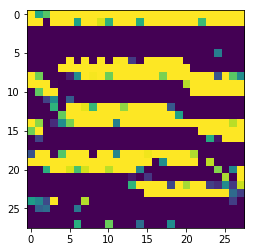

In [11]:
plt.imshow(image)

In [12]:
image=np.reshape(image,[1,784])
# x_batch, y_true_batch, _ = data.random_batch(batch_size=2)
# x_batch.shape

In [13]:
# x_batch, y_true_batch, _ = data.random_batch(batch_size=1)
answer=style_matrix(image)

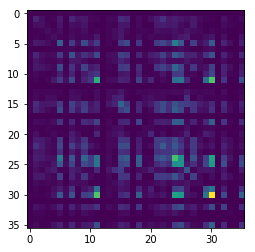

In [22]:
plt.imshow(answer[0,:,:])

In [15]:
# x_batch, y_true_batch, _ = data.random_batch(batch_size=1)
five=data.x_train[data.y_train_cls==1,:]
answer2=style_matrix(five)

In [16]:
temp=(answer-answer2).flatten()

In [17]:
np.sum(temp**2)

49395122000.0

In [18]:
# x_batch, y_true_batch, _ = data.random_batch(batch_size=1000)
data.x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
five=data.x_train[data.y_train_cls==5,:]

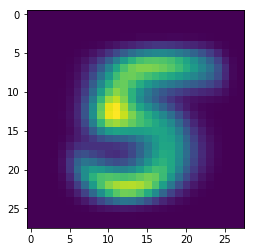

In [23]:
# plt.imshow(np.mean(five,axis=1)
plt.imshow(np.reshape(np.mean(five,axis=0),[28,28]))

In [24]:
def optfunc(weight):
    image = optimize_image(conv_id=1, feature=32,
                               show_progress=False,
                               num_iterations=30,weight=weight)
    answer=style_matrix(np.reshape(image,[1,784]))
    five=data.x_train[data.y_train_cls==1,:]
    answer2=style_matrix(five)
    temp1=(answer-answer2).flatten()
    return np.sqrt(np.sum(temp1**2))

In [25]:
we=np.zeros([36,1])
we[11,0]=1
optfunc(we)

215793.36

In [38]:
num=20
s = np.random.uniform(0,1,(10,num))
tt=np.sum(s,axis=0)
we=s/tt
we=np.append(we,np.zeros((26,num)),axis=0)


In [39]:
we

array([[0.01493684, 0.19077074, 0.07724226, 0.05441263, 0.07823018,
        0.11546845, 0.17102502, 0.16782497, 0.10031867, 0.19362072,
        0.0181802 , 0.06516869, 0.04106129, 0.13062384, 0.07622592,
        0.10662115, 0.06716949, 0.05032604, 0.01563716, 0.08469243],
       [0.10610235, 0.12022259, 0.21110578, 0.10048645, 0.12047768,
        0.14555572, 0.01184503, 0.00495473, 0.02085676, 0.2490397 ,
        0.09199657, 0.12356838, 0.00298559, 0.14495227, 0.08154027,
        0.14368195, 0.14517643, 0.13634848, 0.06397667, 0.14602212],
       [0.15573867, 0.1398714 , 0.2392329 , 0.20436351, 0.19233297,
        0.17081087, 0.07016563, 0.0454562 , 0.13478186, 0.0089845 ,
        0.04718601, 0.07425147, 0.07130279, 0.13052279, 0.18291455,
        0.16782665, 0.0792084 , 0.00924767, 0.02160041, 0.02322894],
       [0.00388256, 0.07915808, 0.05814125, 0.21254229, 0.22869598,
        0.1810667 , 0.0333698 , 0.04492081, 0.12101085, 0.06157922,
        0.19487424, 0.00789348, 0.21360952, 0

In [48]:
y=[]
for i in range(num):
    tte=we[:,i]
    y.append(-optfunc(tte[:,np.newaxis]))
print(y)
fitness=y

[-195156.06, -152978.5, -182967.16, -159850.16, -176988.44, -161413.06, -176131.73, -180777.17, -179396.05, -163016.16, -176719.44, -181990.77, -187408.53, -192801.34, -180444.3, -165414.36, -195695.44, -182560.17, -196469.1, -189243.7]


In [49]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
def select_mating_pool(pop, fitness, num_parents):

    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.

#     parents = numpy.empty((num_parents, pop.shape[1]))
    parents = np.empty((pop.shape[0],num_parents))

    for parent_num in range(num_parents):

        max_fitness_idx = np.where(fitness == np.max(fitness))

        max_fitness_idx = max_fitness_idx[0][0]

        parents[:,parent_num] = pop[:,max_fitness_idx]

        fitness[max_fitness_idx] = -99999999999

    return parents

In [52]:
parents=select_mating_pool(we,fitness,5)
parents.shape

(36, 5)

In [56]:
def crossover(parents, offspring_size):
     offspring = np.empty(offspring_size)
     # The point at which crossover takes place between two parents. Usually, it is at the center.
     crossover_point = np.uint8(offspring_size[1]/2)
 
     for k in range(offspring_size[1]):
         # Index of the first parent to mate.
         parent1_idx = k%parents.shape[1]
         # Index of the second parent to mate.
         parent2_idx = (k+1)%parents.shape[1]
         # The new offspring will have its first half of its genes taken from the first parent.
         offspring[0:crossover_point,k] = parents[0:crossover_point,parent1_idx]
         # The new offspring will have its second half of its genes taken from the second parent.
         offspring[crossover_point:,k] = parents[crossover_point:,parent2_idx]
     return offspring

In [59]:
offspring_size=[36,10]
offspring=crossover(parents, offspring_size)

In [76]:
def mutation(offspring_crossover):

    # Mutation changes a single gene in each offspring randomly.

    for idx in range(offspring_crossover.shape[1]):

        # The random value to be added to the gene.

        random_value = np.random.uniform(-1.0, 1.0, [10])*0.1

        offspring_crossover[:10,idx] = offspring_crossover[:10,idx] + random_value

    return offspring_crossover

In [75]:
# # offspring[:10,5]+np.random.uniform(-1.0, 1.0, [10,1])*0.1
# # offspring.shape[1]
# idx=5
# random_value = np.random.uniform(-1.0, 1.0, [10])*0.1
# # random_value
# offspring[:10,idx] = offspring[:10,idx] + random_value
# offspring[:10,idx] + random_value
# # offspring[:10,idx]

array([ 0.21270554,  0.1179453 ,  0.04204391, -0.05446782,  0.32355796,
        0.20610998,  0.12799933,  0.25346487,  0.20840728,  0.02571764])

In [77]:
mutation(offspring)

array([[ 0.13051684,  0.02363997, -0.04315603,  0.03400203,  0.05224166,
         0.24548547,  0.11683839,  0.12976504,  0.0802495 ,  0.01075802],
       [-0.09289498,  0.1459717 ,  0.07253085,  0.16871698,  0.01546768,
         0.14357892,  0.0246792 ,  0.20621322,  0.25621741, -0.04552562],
       [ 0.02777188,  0.09269065,  0.02788935,  0.21054905, -0.00892496,
        -0.00093564,  0.07172852,  0.08897089,  0.14162095,  0.14361437],
       [ 0.0157062 ,  0.08607441,  0.22904256,  0.11736897,  0.28944317,
         0.03203459,  0.09951931,  0.09426058,  0.01802388,  0.29871417],
       [ 0.25161916, -0.03260488,  0.07765631,  0.09054168,  0.07887994,
         0.17390097,  0.01429314,  0.2009497 ,  0.00206686, -0.02082197],
       [ 0.28877   ,  0.1262356 , -0.03317334,  0.28858671,  0.14955915,
         0.23101739,  0.17691461, -0.01000145,  0.15499831,  0.14924754],
       [ 0.15220608,  0.2589239 ,  0.03177284,  0.03743814, -0.02538593,
         0.08093404,  0.17753083,  0.14375977

In [106]:
num=20
s = np.random.uniform(0,1,(10,num))
tt=np.sum(s,axis=0)
we=s/tt
we=np.append(we,np.zeros((26,num)),axis=0)

In [107]:
we.shape

(36, 20)

In [108]:
num2=10
y=[]
results=[]
final=we
generations=100
for iter in range(generations):
    for i in range(we.shape[1]):
        tte=we[:,i]
        y.append(-optfunc(tte[:,np.newaxis]))
    results.append(np.mean(y[-20:-1]))
    print(results)
    # fitness=y
    parents=select_mating_pool(final,y,10)
    offspring_size=[36,20]
    offspring=crossover(parents, offspring_size)
    we=mutation(offspring)
    final=np.append(final,we,axis=1)
#     final.append(we)
# parents.shape

[-180769.14]
[-180769.14, -171123.12]
[-180769.14, -171123.12, -162643.67]
[-180769.14, -171123.12, -162643.67, -150625.31]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.7

[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -50315.566, -52242.43, -50945.473, -52350.754, -49979.1, -51115.41]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -50315.566, -52242.43, -50945.473, -52350.754, -49979.1, -51115.41, -50766.637]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945,

[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -50315.566, -52242.43, -50945.473, -52350.754, -49979.1, -51115.41, -50766.637, -49926.625, -51786.926, -50630.016, -53513.668, -52595.76, -51424.71, -50475.79, -52376.914, -49524.53, -49991.133, -50718.324, -49997.555, -50390.84, -50441.953, -50088.34]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -5

[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -50315.566, -52242.43, -50945.473, -52350.754, -49979.1, -51115.41, -50766.637, -49926.625, -51786.926, -50630.016, -53513.668, -52595.76, -51424.71, -50475.79, -52376.914, -49524.53, -49991.133, -50718.324, -49997.555, -50390.84, -50441.953, -50088.34, -51750.363, -49692.76, -49287.625, -49843.55, -49674.223, -50124.156, -49412.703, -50853.504, -49569.305, -49420.42, -49278.926, -48958.516]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242,

[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -50315.566, -52242.43, -50945.473, -52350.754, -49979.1, -51115.41, -50766.637, -49926.625, -51786.926, -50630.016, -53513.668, -52595.76, -51424.71, -50475.79, -52376.914, -49524.53, -49991.133, -50718.324, -49997.555, -50390.84, -50441.953, -50088.34, -51750.363, -49692.76, -49287.625, -49843.55, -49674.223, -50124.156, -49412.703, -50853.504, -49569.305, -49420.42, -49278.926, -48958.516, -48383.31, -48765.9, -48329.24, -49034.42, -48734.207, -49804.24, -49409.29, -49897.1, -49441.99, -48940.234, -48777.816]
[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -8

[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -50315.566, -52242.43, -50945.473, -52350.754, -49979.1, -51115.41, -50766.637, -49926.625, -51786.926, -50630.016, -53513.668, -52595.76, -51424.71, -50475.79, -52376.914, -49524.53, -49991.133, -50718.324, -49997.555, -50390.84, -50441.953, -50088.34, -51750.363, -49692.76, -49287.625, -49843.55, -49674.223, -50124.156, -49412.703, -50853.504, -49569.305, -49420.42, -49278.926, -48958.516, -48383.31, -48765.9, -48329.24, -49034.42, -48734.207, -49804.24, -49409.29, -49897.1, -49441.99, -48940.234, -48777.816, -48338.7, -48708.438, -48666.387, -49041.53, -49057.312, -49529.81, -48691.695, -48837.285, -48962.83]
[-180769

[-180769.14, -171123.12, -162643.67, -150625.31, -140076.75, -126998.35, -112619.66, -96576.516, -86576.945, -80359.26, -79872.72, -74500.95, -73547.96, -67913.48, -69543.39, -64272.52, -61557.074, -57648.637, -56712.426, -58310.242, -55393.24, -56747.95, -60075.92, -53818.21, -55537.71, -51626.508, -57234.605, -52829.145, -52941.766, -55757.367, -52966.004, -52690.19, -50315.566, -52242.43, -50945.473, -52350.754, -49979.1, -51115.41, -50766.637, -49926.625, -51786.926, -50630.016, -53513.668, -52595.76, -51424.71, -50475.79, -52376.914, -49524.53, -49991.133, -50718.324, -49997.555, -50390.84, -50441.953, -50088.34, -51750.363, -49692.76, -49287.625, -49843.55, -49674.223, -50124.156, -49412.703, -50853.504, -49569.305, -49420.42, -49278.926, -48958.516, -48383.31, -48765.9, -48329.24, -49034.42, -48734.207, -49804.24, -49409.29, -49897.1, -49441.99, -48940.234, -48777.816, -48338.7, -48708.438, -48666.387, -49041.53, -49057.312, -49529.81, -48691.695, -48837.285, -48962.83, -48999.9

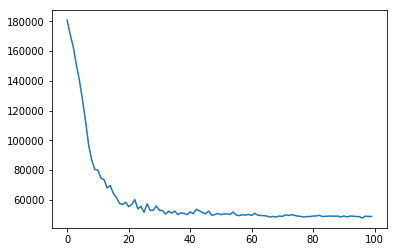

In [113]:
plt.plot(-np.array(results))
plt.savefig('matching_error.svg',bbox_inches='tight',dpi=300)

In [116]:
image = optimize_image(conv_id=1, feature=32,
                               show_progress=True,
                               num_iterations=30,weight=np.mean(we,1)[:,np.newaxis])

# y

Iteration: 0
Predicted class: 3, score:  38.40%
Gradient min: -0.011962, max:  0.004475, stepsize:    380.01
Loss: -0.9024338

Iteration: 1
Predicted class: 2, score:  97.64%
Gradient min: -0.010807, max:  0.005313, stepsize:    372.10
Loss: -0.2508577

Iteration: 2
Predicted class: 2, score:  80.85%
Gradient min: -0.012497, max:  0.004235, stepsize:    371.85
Loss: -0.041272465

Iteration: 3
Predicted class: 2, score:  94.34%
Gradient min: -0.010722, max:  0.004706, stepsize:    370.42
Loss: -0.06925687

Iteration: 4
Predicted class: 2, score:  92.24%
Gradient min: -0.012421, max:  0.005291, stepsize:    362.42
Loss: -0.09019166

Iteration: 5
Predicted class: 2, score:  98.97%
Gradient min: -0.010623, max:  0.006286, stepsize:    374.16
Loss: -0.108166814

Iteration: 6
Predicted class: 2, score:  85.50%
Gradient min: -0.010868, max:  0.006074, stepsize:    381.91
Loss: -0.10874013

Iteration: 7
Predicted class: 2, score:  98.76%
Gradient min: -0.012529, max:  0.006711, stepsize:    36

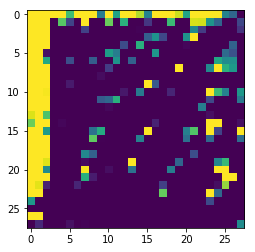

In [117]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# # Fit to data using Maximum Likelihood Estimation of the parameters
# gp.fit(we.T, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
# y_pred, sigma = gp.predict(x, return_std=True)
plt.imshow(image)

In [44]:
# # y_pred, sigma = gp.predict(x, return_std=True)
# x=np.random.uniform(0,1,(1,36))
# tt=np.sum(x,axis=0)
# # np.sum(s/tt,axis=0)
# x=x/tt
# y_pred, sigma = gp.predict(x, return_std=True)

In [45]:
# y_pred

array([1.4063268e-120])